In [2]:
import pandas as pd

In [3]:
raw_data = pd.read_csv('MIMIC EMR.csv')

/Users/zuzu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## 病历文本 raw data
raw_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [5]:
# subject mortality table
mortality_data = pd.read_csv('subject_mortality_table.csv')

In [6]:
mortality_data.head()

,Unnamed: 0,SUBJECT_ID,Death
0,1,22,0
1,2,24,0
2,3,25,0
3,4,26,0
4,5,27,0


In [7]:
# add the mortality label to raw data
df1 = raw_data.merge(mortality_data, on='SUBJECT_ID', how = 'outer')

In [8]:
filtered_df = df1[df1.Death.notnull()]

In [9]:
# multiple records for the same patient
# need to combine all the records for the same patient
filtered_df.shape

(1344425, 13)

In [10]:
#print(filtered_df[filtered_df.SUBJECT_ID == 22532]['TEXT'][4])
#print(filtered_df[filtered_df.SUBJECT_ID == 22532]['TEXT'][5])
#print(filtered_df[filtered_df.SUBJECT_ID == 22532]['TEXT'][6])
#print(filtered_df[filtered_df.SUBJECT_ID == 22532]['TEXT'][7])

In [11]:
finaldata = filtered_df.groupby('SUBJECT_ID')['TEXT'].sum().reset_index()

In [12]:
finaldata.shape

(38983, 2)

In [13]:
# subject ID, combined text description and mortality label
finaldata2 = finaldata.merge(mortality_data, on='SUBJECT_ID', how='left')

In [14]:
finaldata2.head()

,SUBJECT_ID,TEXT,Unnamed: 0,Death
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...,118,0
1,3,Admission Date: [**2101-10-20**] Discharg...,119,0
2,4,Admission Date: [**2191-3-16**] Discharge...,120,0
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...,121,0
4,6,Admission Date: [**2175-5-30**] Dischar...,122,0


# documents 

In [15]:
data_text = finaldata2[['SUBJECT_ID','TEXT','Death']]
data_text['index'] = data_text.index
documents = data_text

In [16]:
documents['TEXT'].isnull().values.any()

False

In [17]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/zuzu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
stemmer = PorterStemmer()

In [19]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [20]:
#doc_sample = documents[documents['index'] == 4310].values[0][1]
#print('original document: ')
#words = []
#for word in doc_sample.split(' '):
#    words.append(word)
#print(words)
#print('\n\n tokenized and lemmatized document: ')
#print(preprocess(doc_sample))

# processed_docs (lemmatized)

In [21]:
processed_docs = documents['TEXT'].astype(str).map(preprocess)
processed_docs[:10]

0    [nurs, transfer, note, admit, nicu, sepsi, eva...
1    [admiss, date, discharg, date, date, birth, se...
2    [admiss, date, discharg, date, date, birth, se...
3    [triag, note, know, lastnam, deliv, week, gest...
4    [admiss, date, discharg, date, date, birth, se...
5    [neonatolog, patient, term, infant, send, nicu...
6    [babygram, chest, port, clip, clip, number, ra...
7    [admiss, date, discharg, date, date, birth, se...
8    [admiss, date, discharg, date, date, birth, se...
9    [admiss, date, discharg, date, date, birth, se...
Name: TEXT, dtype: object

# Bag of words dataset

## create dictonary first

In [22]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 administ
1 admit
2 antibiot
3 apgar
4 ask
5 assess
6 attend
7 babi
8 bilater
9 blood
10 bowel


In [23]:
# word must appear >15 times, and no more than 50% documents
dictionary.filter_extremes(no_below=15, no_above=0.5)

## bow_corpus

In [24]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(1, 1),
 (2, 1),
 (3, 3),
 (5, 1),
 (8, 2),
 (9, 2),
 (11, 1),
 (14, 1),
 (15, 2),
 (16, 2),
 (18, 1),
 (19, 2),
 (20, 1),
 (21, 2),
 (22, 1),
 (23, 1),
 (24, 1),
 (27, 1),
 (30, 1),
 (32, 4),
 (35, 2),
 (36, 2),
 (37, 1),
 (39, 1),
 (40, 1),
 (148, 1),
 (278, 1),
 (325, 1),
 (414, 1),
 (616, 1),
 (782, 2),
 (902, 1),
 (1027, 1),
 (1359, 2),
 (1365, 2),
 (1366, 1),
 (1367, 2),
 (1372, 1),
 (1605, 1),
 (1627, 1),
 (1835, 1),
 (3982, 1),
 (4004, 1),
 (4014, 1),
 (5108, 1),
 (5920, 1),
 (10804, 1)]

# TF-IDF

## corpus_tfidf

In [25]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
#from pprint import pprint
#for doc in corpus_tfidf:
#    pprint(doc)
#    break

# Running LDA using Bag of Words

In [26]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=50, id2word=dictionary, passes=2, workers=2)

In [123]:
# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

# Running LDA using TF-IDF

In [28]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=50, id2word=dictionary, passes=2, workers=4)

In [29]:
# store the total 50 topics
total_topics = [None]*50

for idx, topic in lda_model_tfidf.print_topics(-1):
    total_topics[idx] = topic

In [31]:
documents.shape

(38983, 4)

In [32]:
len(bow_corpus)

38983

# try TF-IDF first

In [34]:
import numpy as n
documents["Topic"] = np.nan

In [35]:
# for i in range(0, len(bow_corpus), 1):
#     for index, score in sorted(lda_model_tfidf[bow_corpus[i]], key=lambda tup: -1*tup[1]):
#         print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))
#         ##sample['Topic'][i]=lda_model_tfidf.print_topic(index, 10)

### give each patient in documents dataframe a topic feature ('topic' + 'label') which the patient scores the highest among all 50 features (didn't use for later classification)

In [36]:
import numpy as np
topic_list=[None]*38983

for i in range(0, len(bow_corpus), 1):
    for index, score in sorted(lda_model_tfidf[bow_corpus[i]], key=lambda tup: -1*tup[1]):
        ##print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))
        ##topic_list[i] = lda_model_tfidf.print_topic(index, 10)
        topic_list[i] = lda_model_tfidf.print_topic(index, 10)

In [39]:
documents['Topic'] = topic_list

In [42]:
##documents.loc[((new_data['year'] >= 1932) & (new_data['year'] < 1942)), 'label'] = 10
def calculate_label(row, mylist):
    for i in range(0,50,1):
        if (row['Topic'] == mylist[i]):
            return i

documents['label'] = documents.apply(calculate_label, mylist = total_topics, axis=1)

In [61]:
len(bow_corpus)

38983

### give each patient in documents dataframe a topic distribution ('vector') feature (used later for classification)

In [66]:
train_vecs = []
for i in range(0,len(bow_corpus),1):
    top_topics = lda_model_tfidf.get_document_topics(bow_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(50)]
    train_vecs.append(topic_vec)

In [67]:
documents['vector'] = train_vecs

In [68]:
documents.head()

,SUBJECT_ID,TEXT,Death,index,Topic,label,vector
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...,0,0,"0.040*""infant"" + 0.019*""sepsi"" + 0.019*""matern...",24,"[0.00031749936, 0.00031749936, 0.00031749936, ..."
1,3,Admission Date: [**2101-10-20**] Discharg...,0,1,"0.003*""action"" + 0.002*""picc"" + 0.002*""intub"" ...",26,"[8.785573e-06, 8.785573e-06, 8.785573e-06, 8.7..."
2,4,Admission Date: [**2191-3-16**] Discharge...,0,2,"0.005*""valv"" + 0.003*""mitral"" + 0.003*""pneumon...",37,"[9.52155e-06, 9.52155e-06, 9.52155e-06, 9.5215..."
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...,0,3,"0.026*""infant"" + 0.013*""nicu"" + 0.012*""sepsi"" ...",6,"[0.00016547297, 0.00016547297, 0.00016547297, ..."
4,6,Admission Date: [**2175-5-30**] Dischar...,0,4,"0.013*""valv"" + 0.008*""cabg"" + 0.007*""mitral"" +...",40,"[1.7062865e-05, 1.7062865e-05, 1.7062865e-05, ..."


# balance the tfidf data with same amount of 0/1

In [84]:
dead = documents[documents.Death == 1]
dead.shape

(4351, 7)

In [86]:
alive = documents[documents.Death == 0].sample(n=4351)
alive.shape

(4351, 7)

In [88]:
sample = pd.concat([dead, alive], ignore_index=True)
sample.shape

(8702, 7)

In [104]:
sample_vecs = []
for i in range(0,8702,1): 
    sample_vecs.append(sample['vector'][i])

# Logistic Regression

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

#X = documents['label'].values.reshape(-1,1)
#y = documents['Death']

X = np.array(sample_vecs)
y = np.array(sample.Death)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/zuzu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [169]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [170]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,905,387
True 1,283,1036


In [171]:
import matplotlib.pyplot as plt 
%matplotlib inline

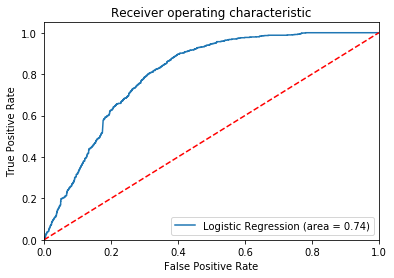

In [172]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Random Forest

### for some reason I cannot import RF classifer

In [163]:
#from sklearn.ensemble import RandomForestClassifier

In [164]:
# rf = RandomForestClassifier()
# rf.fit(X_train,y_train.ravel())

In [165]:
# y_pred_rf = rf.predict(X_test)
# metrics.accuracy_score(y_test, y_pred_rf)

In [166]:
# pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf), 
#              columns=['Predicted 0','Predicted 1'],
#              index=['True 0', 'True 1'])

# Neural Network

In [173]:
from sklearn.neural_network import MLPClassifier

In [174]:
NN = MLPClassifier()
NN.fit(X_train,y_train)

/Users/zuzu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [176]:
y_pred_nn = NN.predict(X_test)
metrics.accuracy_score(y_test, y_pred_nn)

0.7629260819609345

In [177]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_nn), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,927,365
True 1,254,1065


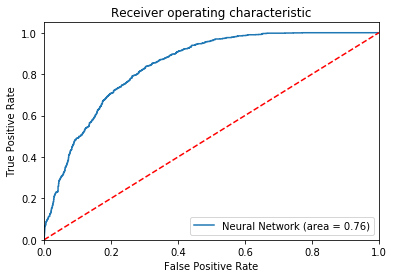

In [178]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, NN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, NN.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Neural Network (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
# overfit underfit
# training & test 的 auc

# Try Bag of Words

In [125]:
train_vecs_bag = []
for i in range(0,len(bow_corpus),1):
    top_topics = lda_model.get_document_topics(bow_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(50)]
    train_vecs_bag.append(topic_vec)

In [126]:
documents['vector_bag'] = train_vecs_bag

In [127]:
documents.head()

,SUBJECT_ID,TEXT,Death,index,Topic,label,vector,vector_bag
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...,0,0,"0.040*""infant"" + 0.019*""sepsi"" + 0.019*""matern...",24,"[0.00031749936, 0.00031749936, 0.00031749936, ...","[0.00031748624, 0.00031748624, 0.00031748624, ..."
1,3,Admission Date: [**2101-10-20**] Discharg...,0,1,"0.003*""action"" + 0.002*""picc"" + 0.002*""intub"" ...",26,"[8.785573e-06, 8.785573e-06, 8.785573e-06, 8.7...","[8.694353e-06, 8.694353e-06, 8.694353e-06, 0.2..."
2,4,Admission Date: [**2191-3-16**] Discharge...,0,2,"0.005*""valv"" + 0.003*""mitral"" + 0.003*""pneumon...",37,"[9.52155e-06, 9.52155e-06, 9.52155e-06, 9.5215...","[9.449701e-06, 9.449701e-06, 9.449701e-06, 9.4..."
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...,0,3,"0.026*""infant"" + 0.013*""nicu"" + 0.012*""sepsi"" ...",6,"[0.00016547297, 0.00016547297, 0.00016547297, ...","[0.00016534702, 0.00016534702, 0.00016534702, ..."
4,6,Admission Date: [**2175-5-30**] Dischar...,0,4,"0.013*""valv"" + 0.008*""cabg"" + 0.007*""mitral"" +...",40,"[1.7062865e-05, 1.7062865e-05, 1.7062865e-05, ...","[1.6916378e-05, 1.6916378e-05, 1.6916378e-05, ..."


### balance the bag of words data

In [130]:
dead2 = documents[documents.Death == 1]
alive2 = documents[documents.Death == 0].sample(n=4351)
sample2 = pd.concat([dead2, alive2], ignore_index=True)
sample2.head()

,SUBJECT_ID,TEXT,Death,index,Topic,label,vector,vector_bag
0,9,Admission Date: [**2149-11-9**] Dischar...,1,7,"0.013*""subdur"" + 0.011*""hemorrhag"" + 0.006*""fr...",25,"[1.316798e-05, 1.316798e-05, 1.316798e-05, 1.3...","[1.3052774e-05, 1.3052774e-05, 1.3052774e-05, ..."
1,12,Admission Date: [**2104-8-7**] Discharge ...,1,10,"0.044*""infant"" + 0.018*""feed"" + 0.011*""parent""...",19,"[2.1973161e-05, 2.1973161e-05, 2.1973161e-05, ...","[2.1674039e-05, 2.1674039e-05, 2.1674039e-05, ..."
2,31,Admission Date: [**2108-8-22**] Discharge...,1,23,"0.044*""infant"" + 0.018*""feed"" + 0.011*""parent""...",19,"[1.2876876e-05, 1.2876876e-05, 1.2876876e-05, ...","[1.2677583e-05, 1.2677583e-05, 1.2677583e-05, ..."
3,56,Admission Date: [**2104-1-2**] D...,1,43,"0.009*""esophagectomi"" + 0.007*""stab"" + 0.004*""...",41,"[3.3546537e-05, 3.3546537e-05, 3.3546537e-05, ...","[3.338236e-05, 3.338236e-05, 3.338236e-05, 0.3..."
4,91,Admission Date: [**2177-4-23**] Discharge...,1,71,"0.013*""subdur"" + 0.011*""hemorrhag"" + 0.006*""fr...",25,"[1.1382325e-05, 1.1382325e-05, 1.1382325e-05, ...","[1.1162137e-05, 1.1162137e-05, 1.1162137e-05, ..."


In [131]:
sample_vecs2 = []
for i in range(0,8702,1): 
    sample_vecs2.append(sample2['vector_bag'][i])

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

X = np.array(sample_vecs2)
y = np.array(sample2.Death)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/zuzu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [180]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83


In [181]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,1049,243
True 1,200,1119


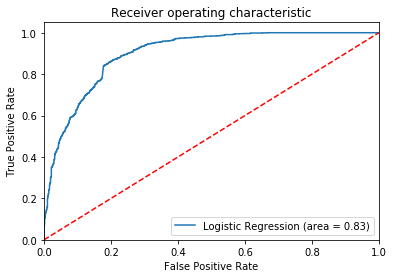

In [182]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [186]:
NN = MLPClassifier()
NN.fit(X_train,y_train)

/Users/zuzu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [187]:
y_pred_nn = NN.predict(X_test)
metrics.accuracy_score(y_test, y_pred_nn)

0.8494829567215626

In [188]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_nn), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,1085,207
True 1,186,1133


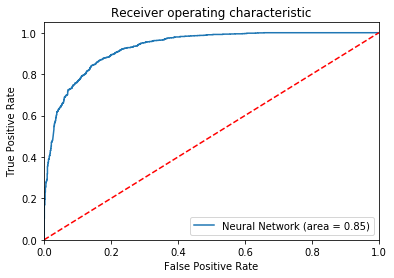

In [189]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, NN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, NN.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Neural Network (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# unbalanced data using bag of words

In [194]:
X2 = np.array(train_vecs_bag)
y2 = np.array(documents.Death)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=0)
logreg.fit(X_train2, y_train2)

/Users/zuzu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [195]:
y_pred2 = logreg2.predict(X_test2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test2, y_test2)))

Accuracy of logistic regression classifier on test set: 0.91


In [196]:
pd.DataFrame(metrics.confusion_matrix(y_test2, y_pred2), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,10239,179
True 1,854,423


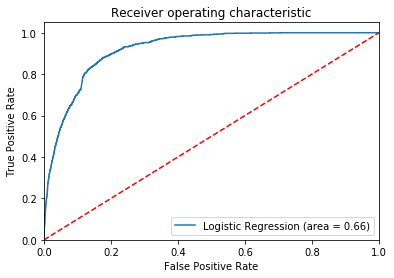

In [197]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test2, logreg.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test2, logreg.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [198]:
NN.fit(X_train2,y_train2)

/Users/zuzu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [199]:
y_pred_nn2 = NN.predict(X_test2)
metrics.accuracy_score(y_test2, y_pred_nn2)

0.9264643009833262

In [200]:
pd.DataFrame(metrics.confusion_matrix(y_test2, y_pred_nn2), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,10107,311
True 1,549,728


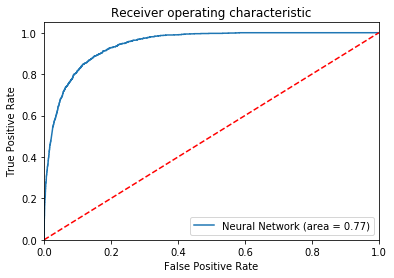

In [201]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test2, NN.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test2, NN.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Neural Network (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()